In [1]:
HOST = "35.197.98.125"
USER = "admin"
PASSWORD = "floody"
SIM_DB = "curw_sim"
FCST_DB = "curw_fcst"
OBS_DB = "curw_obs"
PORT = 3306
RESOURCE_PATH = '/home/hasitha/PycharmProjects/DSS-Framework/resources/shape_files'

In [30]:
import pandas as pd
import pymysql
import os
import sys
from decimal import Decimal
from shapely.geometry import Polygon, Point, shape
from datetime import datetime, timedelta
import fiona
from functools import reduce
import matplotlib.pyplot as plt

In [12]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [13]:
def get_single_result(db_connection, query):
    cur = db_connection.cursor()
    cur.execute(query)
    row = cur.fetchone()
    return row


def get_multiple_result(db_connection, query):
    cur = db_connection.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    return rows


def get_latest_fgt(fcst_connection, hash_id, start_time):
    print('get_latest_fgt|[hash_id, start_time] : ', [hash_id, start_time])
    cur = fcst_connection.cursor()
    cur.callproc('getLatestFGTs', (hash_id, start_time))
    rows = cur.fetchall()
    if rows is not None:
        if rows:
            print('get_latest_fgts|rows: ', rows)
            return rows[0]['fgt'].strftime('%Y-%m-%d %H:%M:%S')
        else:
            return None
    else:
        return None


def is_inside_basin(shape_file, latitude, longitude):
    multipol = fiona.open(shape_file)
    multi = next(iter(multipol))
    point = Point(longitude, latitude)
    return point.within(shape(multi['geometry']))


def get_wrf_basin_stations(fcst_connection, shape_file):
    basin_points = []
    sql_query = 'select id,latitude,longitude from curw_fcst.station where description=\'WRF point\' ' \
                'and latitude between 6.6 and 7.4 and longitude between 79.6 and 81.0'
    rows = get_multiple_result(fcst_connection, sql_query)
    for row in rows:
        latitude = Decimal(row['latitude'])
        longitude = Decimal(row['longitude'])
        if is_inside_basin(shape_file, latitude, longitude):
            basin_points.append(row['id'])
    return basin_points


def get_wrf_station_hash_ids(fcst_connection, sim_tag, wrf_model_id, basin_points):
    hash_ids = []
    basin_points_str = ','.join(str(x) for x in basin_points)
    sql_query = 'select id from curw_fcst.run where sim_tag=\'{}\' and source={} and ' \
                'station in ({})'.format(sim_tag, wrf_model_id, basin_points_str)
    rows = get_multiple_result(fcst_connection, sql_query)
    for row in rows:
        hash_ids.append(row['id'])
    return hash_ids


def get_station_timeseries(fcst_connection, hash_id, latest_fgt, start_time, end_time):
    sql_query = 'select time,value from curw_fcst.data where id=\'{}\' and time>=\'{}\' ' \
                'and time<=\'{}\' and fgt=\'{}\''.format(hash_id, start_time, end_time, latest_fgt)
    rows = get_multiple_result(fcst_connection, sql_query)
    df = pd.DataFrame(data=rows, columns=['time', 'value'])
    df['time'] = pd.to_datetime(df['time'])
    resample_df = (df.set_index('time').resample('5T').first().reset_index().reindex(columns=df.columns))
    interpolate_df = resample_df.interpolate(method='linear', limit_direction='forward')
    interpolate_df['value'].fillna(Decimal(0.0), inplace=True)
    return interpolate_df.set_index(keys='time')


def get_obs_basin_stations(obs_connection, shape_file):
    basin_points = []
    sql_query = 'select id,latitude,longitude from curw_obs.station where station_type=\'CUrW_WeatherStation\' ' \
                'and longitude between 79.6 and 81.0;'
    rows = get_multiple_result(obs_connection, sql_query)
    for row in rows:
        latitude = Decimal(row['latitude'])
        longitude = Decimal(row['longitude'])
        if is_inside_basin(shape_file, latitude, longitude):
            basin_points.append(row['id'])
    return basin_points


def get_obs_station_hash_ids(obs_connection, basin_points, start_time):
    hash_ids = []
    basin_points_str = ','.join(str(x) for x in basin_points)
    sql_query = 'select id from curw_obs.run where variable=10 and unit=9 and ' \
                'station in ({}) and end_date>\'{}\';'.format(basin_points_str,start_time)
    rows = get_multiple_result(obs_connection, sql_query)
    for row in rows:
        hash_ids.append(row['id'])
    return hash_ids


def get_obs_station_timeseries(obs_connection, hash_id, timeseries_start, timeseries_end, max_error):
    data_sql = 'select time,value from curw_obs.data where id=\'{}\' and time >= \'{}\' ' \
               'and time <= \'{}\''.format(hash_id, timeseries_start, timeseries_end)
    try:
        results = get_multiple_result(obs_connection, data_sql)
        if len(results) > 0:
            time_step_count = int((datetime.strptime(timeseries_end, '%Y-%m-%d %H:%M:%S')
                                   - datetime.strptime(timeseries_start, '%Y-%m-%d %H:%M:%S')).total_seconds() / (
                                              60 * 5))
            data_error = ((time_step_count - len(results)) / time_step_count)
            if data_error < 0:
                df = pd.DataFrame(data=results, columns=['time', 'value']).set_index(keys='time')
                return df
            elif data_error < max_error:
                print('data_error : {}'.format(data_error))
                print('filling missing data.')
                formatted_ts = []
                i = 0
                for step in range(time_step_count + 1):
                    tms_step = datetime.strptime(timeseries_start, '%Y-%m-%d %H:%M:%S') + timedelta(
                        minutes=step * 5)
                    if step < len(results):
                        if tms_step == results[i]['time']:
                            formatted_ts.append(results[i])
                        else:
                            formatted_ts.append({'time': tms_step, 'value': Decimal(0)})
                    else:
                        formatted_ts.append({'time': tms_step, 'value': Decimal(0)})
                    i += 1
                df = pd.DataFrame(data=formatted_ts, columns=['time', 'value']).set_index(keys='time')
                # print('get_station_timeseries|df: ', df)
                return df
            else:
                print('data_error : {}'.format(data_error))
                print('Data error is too large')
                return None
        else:
            print('No data.')
            return None
    except Exception as e:
        print('get_timeseries_by_id|data fetch|Exception:', e)
        return None


def get_obs_water_levels(db_connection, start_date, end_date, model='flo2d_150', grid_id='waterlevel_glencourse', method='SF'):
    id_query = 'select id from curw_sim.wl_run where model=\'{}\' and method=\'{}\' and ' \
               'grid_id=\'{}\';'.format(model, method, grid_id)
    print('get_obs_water_levels|id_query : ', id_query)
    id_result = get_single_result(db_connection, id_query)
    print('get_obs_water_levels|id_result : ', id_result)
    hash_id = id_result['id']
    print('get_obs_water_levels|hash_id : ', hash_id)
    if hash_id is not None:
        data_query = 'select time,value from curw_sim.wl_data where id=\'{}\' and time>\'{}\' ' \
                     'and time<\'{}\';'.format(hash_id,start_date, end_date)
        print('get_obs_water_levels|data_query : ', data_query)
        data_result = get_multiple_result(db_connection, data_query)
        print('get_obs_water_levels|data_result : ', data_result)
        return data_result
    return None


def get_discharge_fcst_df(db_connection, start_date, end_date, sim_tag='event_run', source_id=17):
    id_query = 'select id from curw_fcst.run where variable=3 and unit=3 and source={} and sim_tag=\'{}\';'.format(source_id, sim_tag)
    print('get_discharge_fcst_df|id_query : ', id_query)
    id_result = get_single_result(db_connection, id_query)
    print('get_discharge_fcst_df|id_result : ', id_result)
    hash_id = id_result['id']
    print('get_discharge_fcst_df|hash_id : ', hash_id)
    if hash_id is not None:
        data_query = 'select time,value from curw_fcst.data where id=\'{}\' and time>\'{}\' ' \
                     'and time<\'{}\';'.format(hash_id, start_date, end_date)
        print('get_discharge_fcst_df|data_query : ', data_query)
        data_result = get_multiple_result(db_connection, data_query)
        print('get_discharge_fcst_df|data_result : ', data_result)
        df = pd.DataFrame(data=data_result, columns=['time', 'value']).set_index(keys='time')
        df.rename(columns={'value': 'forecast'}, inplace=True)
        return df
    return None

In [14]:
def get_common_start_end(obs_cum_mean_df, fcst_cum_mean_df):
    if len(obs_cum_mean_df.index) - len(fcst_cum_mean_df.index) > 0:
        smallest_df = fcst_cum_mean_df
    else:
        smallest_df = obs_cum_mean_df
    start = smallest_df.iloc[0]['time']
    end = smallest_df.iloc[-1]['time']
    obs_cum_mean_df1 = obs_cum_mean_df[obs_cum_mean_df['time'] >= start]
    obs_cum_mean_df2 = obs_cum_mean_df1[obs_cum_mean_df1['time'] <= end]
    fcst_cum_mean_df1 = fcst_cum_mean_df[fcst_cum_mean_df['time'] >= start]
    fcst_cum_mean_df2 = fcst_cum_mean_df1[fcst_cum_mean_df1['time'] <= end]
    return [obs_cum_mean_df2, fcst_cum_mean_df2]

In [15]:
def get_obs_cum_mean_df(obs_connection, shape_file, start_time, end_time, max_error=0.7):
    basin_points = get_obs_basin_stations(obs_connection, shape_file)
    total_df = None
    station_count = 0
    if len(basin_points) > 0:
        print(basin_points)
        hash_ids = get_obs_station_hash_ids(obs_connection, basin_points, start_time)
        for hash_id in hash_ids:
            df = get_obs_station_timeseries(obs_connection, hash_id, start_time, end_time, max_error)
            if df is not None:
                if station_count == 0:
                    total_df = df
                else:
                    total_df = total_df.add(df, fill_value=0)
                station_count += 1
        if total_df is not None:
            obs_mean_df = total_df['value'] / station_count
            obs_cum_mean_df = obs_mean_df.cumsum()
            return obs_cum_mean_df


def get_fcst_cum_mean_df(fcst_connection, shape_file, sim_tag, wrf_model, start_time, end_time):
    basin_points = get_wrf_basin_stations(fcst_connection, shape_file)
    total_df = None
    station_count = 0
    if len(basin_points) > 0:
        print(basin_points)
        hash_ids = get_wrf_station_hash_ids(fcst_connection, sim_tag, wrf_model, basin_points)
        latest_fgt = get_latest_fgt(fcst_connection, hash_ids[0], start_time)
        if latest_fgt is not None:
            for hash_id in hash_ids:
                df = get_station_timeseries(fcst_connection, hash_id, latest_fgt, start_time, end_time)
                if df is not None:
                    if station_count == 0:
                        total_df = df
                    else:
                        total_df = total_df.add(df, fill_value=0)
                    station_count += 1
            if total_df is not None:
                fcst_mean_df = total_df['value'] / station_count
                fcst_cum_mean_df = fcst_mean_df.cumsum()
                return fcst_cum_mean_df
        else:
            return None

In [32]:
def calculate_wrf_model_mean(sim_tag, wrf_model, start_time, end_time):
    print('calculate_wrf_model_mean|[sim_tag, wrf_model, start_time, end_time]: ',
          [sim_tag, wrf_model, start_time, end_time])
    fcst_connection = pymysql.connect(host=HOST, user=USER, password=PASSWORD, db=FCST_DB,
                                      cursorclass=pymysql.cursors.DictCursor)
    obs_connection = pymysql.connect(host=HOST, user=USER, password=PASSWORD, db=OBS_DB,
                                     cursorclass=pymysql.cursors.DictCursor)
    shape_file = os.path.join(RESOURCE_PATH, 'Kalani_basin_hec_wgs/Kalani_basin_hec_wgs.shp')
    obs_cum_mean_df = get_obs_cum_mean_df(obs_connection, shape_file, start_time, end_time)
    if obs_cum_mean_df is not None and obs_cum_mean_df.empty is False:
        fcst_cum_mean_df = get_fcst_cum_mean_df(fcst_connection, shape_file, sim_tag, wrf_model, start_time, end_time)
        if fcst_cum_mean_df is not None and fcst_cum_mean_df.empty is False:
            obs_cum_mean_df = pd.DataFrame({'time': obs_cum_mean_df.index, 'observed': obs_cum_mean_df.values})
            fcst_cum_mean_df = pd.DataFrame({'time': fcst_cum_mean_df.index, 'forecast': fcst_cum_mean_df.values})
            [formatted_obs_cum_mean_df, formatted_fcst_cum_mean_df] = get_common_start_end(obs_cum_mean_df,
                                                                                           fcst_cum_mean_df)
            compare_cum_mean_df = pd.merge(formatted_obs_cum_mean_df, formatted_fcst_cum_mean_df, left_on='time',
                                           right_on='time')
            test_result_dir = os.path.join('/home/hasitha/PycharmProjects/DSS-Framework/output',
                                           '{}'.format(datetime.now().strftime('%Y-%m-%d')))
            create_dir(test_result_dir)
            fcst_cum_mean_file = os.path.join(test_result_dir, 'fcst_{}_{}_cum_mean.csv'.format(sim_tag, wrf_model))
            formatted_fcst_cum_mean_df.to_csv(fcst_cum_mean_file, encoding='utf-8',index=False)
            obs_cum_mean_file = os.path.join(test_result_dir, 'obs_cum_mean.csv')
            formatted_obs_cum_mean_df.to_csv(obs_cum_mean_file, encoding='utf-8',index=False)
            
            compare_cum_mean_df.observed = pd.to_numeric(compare_cum_mean_df.observed)
            compare_cum_mean_df.forecast = pd.to_numeric(compare_cum_mean_df.forecast)
            rmse = ((compare_cum_mean_df.observed - compare_cum_mean_df.forecast) ** 2).mean() ** .5
            rmse_params = {'sim_tag': sim_tag, 'wrf_model': wrf_model, 'rmse': rmse}
            print('calculate_wrf_model_mean|rmse_params : ', rmse_params)
    fcst_connection.close()
    obs_connection.close()

In [33]:
calculate_wrf_model_mean('dwrf_gfs_d1_00', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_00', 20, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_00', 21, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_00', 22, '2020-05-21 00:00:00', '2020-05-22 00:00:00')

calculate_wrf_model_mean|[sim_tag, wrf_model, start_time, end_time]:  ['dwrf_gfs_d1_00', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00']
[100002, 100003, 100014, 100015, 100031, 100032, 100039, 100040, 100050, 100051, 100053, 100061, 100062, 100065, 100067, 100068, 100070, 100072, 100073, 100074, 100075, 100076, 100087]
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.003472222222222222
filling missing data.
data_error : 0.0
filling missing data.
[1103980, 1103981, 1104079, 1104080, 1104081, 1104082, 1104173, 1104174, 1104176, 1104177, 1104178, 1104179, 1104180, 1104270, 1104271, 1104272, 1104273, 1104274, 1104275, 1104276, 1104277, 1104278, 1104369, 1104370, 1104371, 1104372, 1104373, 1104374, 1104375, 1104376, 1104468, 1104469, 1104470, 1104471, 1104472, 1104473, 1104474, 1104475, 1104567, 1104568, 1104569, 1104570, 1104571, 1104572, 1104573, 1104574, 1104667, 1104668, 1104669, 1104670, 1104671, 1104

In [34]:
calculate_wrf_model_mean('dwrf_gfs_d1_06', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_06', 20, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_06', 21, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_06', 22, '2020-05-21 00:00:00', '2020-05-22 00:00:00')

calculate_wrf_model_mean|[sim_tag, wrf_model, start_time, end_time]:  ['dwrf_gfs_d1_06', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00']
[100002, 100003, 100014, 100015, 100031, 100032, 100039, 100040, 100050, 100051, 100053, 100061, 100062, 100065, 100067, 100068, 100070, 100072, 100073, 100074, 100075, 100076, 100087]
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.003472222222222222
filling missing data.
data_error : 0.0
filling missing data.
[1103980, 1103981, 1104079, 1104080, 1104081, 1104082, 1104173, 1104174, 1104176, 1104177, 1104178, 1104179, 1104180, 1104270, 1104271, 1104272, 1104273, 1104274, 1104275, 1104276, 1104277, 1104278, 1104369, 1104370, 1104371, 1104372, 1104373, 1104374, 1104375, 1104376, 1104468, 1104469, 1104470, 1104471, 1104472, 1104473, 1104474, 1104475, 1104567, 1104568, 1104569, 1104570, 1104571, 1104572, 1104573, 1104574, 1104667, 1104668, 1104669, 1104670, 1104671, 1104

IndexError: list index out of range

In [35]:
calculate_wrf_model_mean('dwrf_gfs_d1_12', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_12', 20, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_12', 21, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_12', 22, '2020-05-21 00:00:00', '2020-05-22 00:00:00')

calculate_wrf_model_mean|[sim_tag, wrf_model, start_time, end_time]:  ['dwrf_gfs_d1_12', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00']
[100002, 100003, 100014, 100015, 100031, 100032, 100039, 100040, 100050, 100051, 100053, 100061, 100062, 100065, 100067, 100068, 100070, 100072, 100073, 100074, 100075, 100076, 100087]
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.003472222222222222
filling missing data.
data_error : 0.0
filling missing data.
[1103980, 1103981, 1104079, 1104080, 1104081, 1104082, 1104173, 1104174, 1104176, 1104177, 1104178, 1104179, 1104180, 1104270, 1104271, 1104272, 1104273, 1104274, 1104275, 1104276, 1104277, 1104278, 1104369, 1104370, 1104371, 1104372, 1104373, 1104374, 1104375, 1104376, 1104468, 1104469, 1104470, 1104471, 1104472, 1104473, 1104474, 1104475, 1104567, 1104568, 1104569, 1104570, 1104571, 1104572, 1104573, 1104574, 1104667, 1104668, 1104669, 1104670, 1104671, 1104

In [36]:
calculate_wrf_model_mean('dwrf_gfs_d1_18', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_18', 20, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_18', 21, '2020-05-21 00:00:00', '2020-05-22 00:00:00')
calculate_wrf_model_mean('dwrf_gfs_d1_18', 22, '2020-05-21 00:00:00', '2020-05-22 00:00:00')

calculate_wrf_model_mean|[sim_tag, wrf_model, start_time, end_time]:  ['dwrf_gfs_d1_18', 19, '2020-05-21 00:00:00', '2020-05-22 00:00:00']
[100002, 100003, 100014, 100015, 100031, 100032, 100039, 100040, 100050, 100051, 100053, 100061, 100062, 100065, 100067, 100068, 100070, 100072, 100073, 100074, 100075, 100076, 100087]
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.0
filling missing data.
data_error : 0.003472222222222222
filling missing data.
data_error : 0.0
filling missing data.
[1103980, 1103981, 1104079, 1104080, 1104081, 1104082, 1104173, 1104174, 1104176, 1104177, 1104178, 1104179, 1104180, 1104270, 1104271, 1104272, 1104273, 1104274, 1104275, 1104276, 1104277, 1104278, 1104369, 1104370, 1104371, 1104372, 1104373, 1104374, 1104375, 1104376, 1104468, 1104469, 1104470, 1104471, 1104472, 1104473, 1104474, 1104475, 1104567, 1104568, 1104569, 1104570, 1104571, 1104572, 1104573, 1104574, 1104667, 1104668, 1104669, 1104670, 1104671, 1104

In [46]:
def get_obs_and_fcst_times(test_date, gfs_hour):
    print('get_obs_and_fcst_times|[test_date, gfs_hour] : ', [test_date, gfs_hour])
    gfs_hour = int(gfs_hour)
    test_date = datetime.strptime(test_date, '%Y-%m-%d')
    test_date = test_date + timedelta(hours=gfs_hour+5, minutes=30)
    ts_start = test_date - timedelta(hours=23,minutes=45)
    ts_end = test_date + timedelta(hours=48)
    print('get_obs_and_fcst_times|ts_start : ', ts_start)
    print('get_obs_and_fcst_times|test_date : ', test_date)
    print('get_obs_and_fcst_times|ts_end : ', ts_end)

In [47]:
get_obs_and_fcst_times('2020-06-22', '18')

get_obs_and_fcst_times|[test_date, gfs_hour] :  ['2020-06-22', '18']
get_obs_and_fcst_times|ts_start :  2020-06-21 23:45:00
get_obs_and_fcst_times|test_date :  2020-06-22 23:30:00
get_obs_and_fcst_times|ts_end :  2020-06-24 23:30:00


In [19]:
obs_file_path = '/home/hasitha/PycharmProjects/DSS-Framework/output/2020-06-23/obs_cum_mean.csv'
fcst_file_path = '/home/hasitha/PycharmProjects/DSS-Framework/output/2020-06-23/fcst_dwrf_gfs_d1_18_19_cum_mean.csv'

In [27]:
obs_df = pd.read_csv(obs_file_path)
fcst_df = pd.read_csv(fcst_file_path)
obs_df

,time,observed
0,2020-05-15 23:45:00,0.000000
1,2020-05-15 23:50:00,0.000000
2,2020-05-15 23:55:00,0.000000
3,2020-05-16 00:00:00,0.000000
4,2020-05-16 00:05:00,0.000000
...,...,...
281,2020-05-16 23:10:00,0.066667
282,2020-05-16 23:15:00,0.066667
283,2020-05-16 23:20:00,0.066667
284,2020-05-16 23:25:00,0.066667


In [31]:
plot_df = reduce(lambda x,y: pd.merge(x,y, on='time', how='outer'), [obs_df,fcst_df])
plot_df

,time,observed,forecast
0,2020-05-15 23:45:00,0.000000,0.000000
1,2020-05-15 23:50:00,0.000000,0.000000
2,2020-05-15 23:55:00,0.000000,0.000000
3,2020-05-16 00:00:00,0.000000,0.000345
4,2020-05-16 00:05:00,0.000000,0.000345
...,...,...,...
281,2020-05-16 23:10:00,0.066667,1.239638
282,2020-05-16 23:15:00,0.066667,1.239638
283,2020-05-16 23:20:00,0.066667,1.239638
284,2020-05-16 23:25:00,0.066667,1.239638


Text(0,0.5,'Rainfall (mm)')

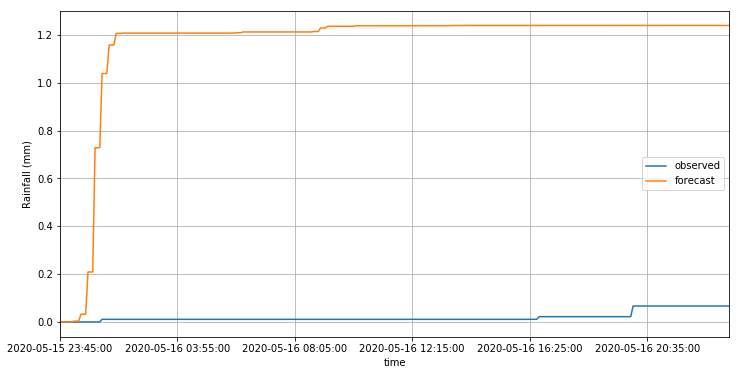

In [32]:
plot_df.plot(x='time', y=['observed','forecast'], kind='line', figsize=(12,6), grid=True).set_ylabel('Rainfall (mm)')